In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import  GridSearchCV

# Time series decomposition
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#Read the dataset:
df=pd.read_csv("NSE-TATA.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.head()


C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


In [2]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

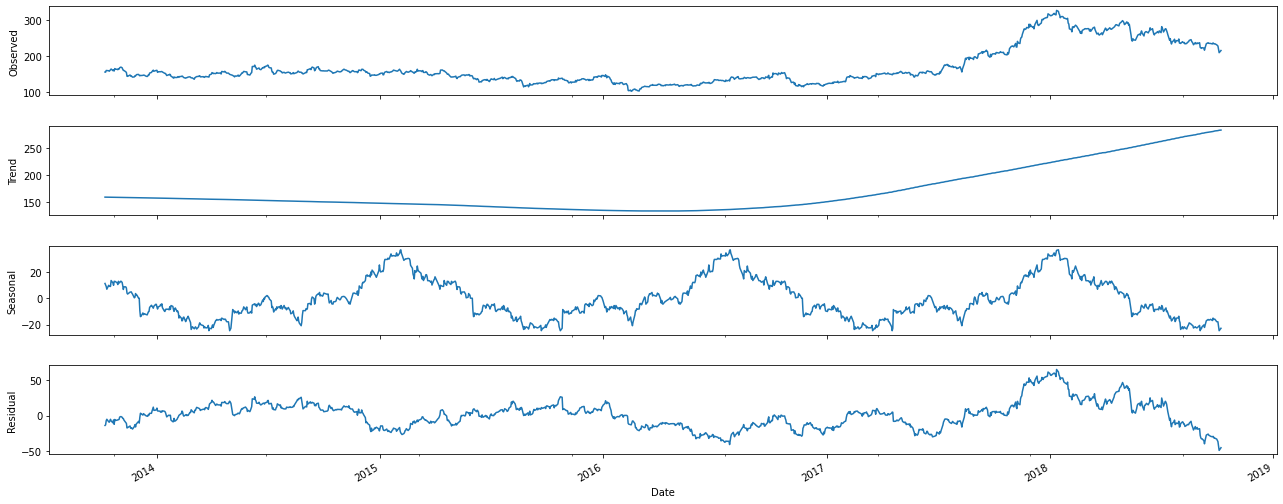

In [3]:
#Decomposition
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

In [4]:
# Technical indicators

##Moving Averages
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [5]:
#Relative Strength Index

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

In [6]:
#MACD

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [7]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

In [8]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

In [9]:
#Drop unnecessary columns
drop_cols = ['Date', 'Open', 'Low', 'High']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

In [10]:
#Split into features and labels
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)
# X_train = train_df.drop(['Stock'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)
# X_valid = valid_df.drop(['Stock'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Last                  841 non-null    float64
 1   Total Trade Quantity  841 non-null    float64
 2   Turnover (Lacs)       841 non-null    float64
 3   EMA_9                 841 non-null    float64
 4   SMA_5                 841 non-null    float64
 5   SMA_10                841 non-null    float64
 6   SMA_15                841 non-null    float64
 7   SMA_30                841 non-null    float64
 8   RSI                   841 non-null    float64
 9   MACD                  841 non-null    float64
 10  MACD_signal           841 non-null    float64
dtypes: float64(11)
memory usage: 72.4 KB


In [13]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[21:52:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:52:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "eval_set", "verbose" } might not be used.

  This may not be accurate due to some par

In [ ]:
%%time

parameters2 = {
    'n_estimators': [400],
    'learning_rate': [0.05],
    'max_depth': [12],
    'gamma': [0.01],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

In [14]:
# %%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=12,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=8, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

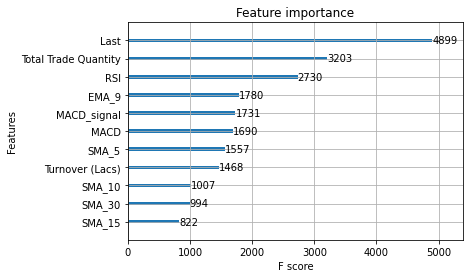

In [15]:
plot_importance(model)

In [16]:
#Calculate and visualize predictions
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [172.75 171.1  167.8  169.5  167.3 ]
y_pred = [171.69734 170.81668 167.46431 169.0785  166.45747]


In [17]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 0.3556815560792252


In [18]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

In [20]:
import utils as u
u.save_model(clf,'XGBoost.txt')

In [13]:
import utils as u
#load & test
eval_set = [(X_train, y_train), (X_valid, y_valid)]
clf2 = u.load_model('XGBoost.txt')
model2 = xgb.XGBRegressor(**clf2.best_params_, objective='reg:squarederror')
model2.fit(X_train, y_train, eval_set=eval_set, verbose=False)
## Calculate and visualize predictions
y_pred2 = model2.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred2[:5]}')

print(f'mean_squared_error = {mean_squared_error(y_test, y_pred2)}')


y_true = [172.75 171.1  167.8  169.5  167.3 ]
y_pred = [171.69734 170.81668 167.46431 169.0785  166.45747]
mean_squared_error = 0.3556815560792252
